# Data Preprocessing
***

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<br>

## Features
***
**Outline**  
[Principal Component Analysis](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 "Towards Data Sciene | PCA using Python (scikit-learn)") & 
[Data loading & preprocessing](https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing "Keras") 
1. Load and normalize data
2. Apply PCA transformation
3. Normalize principal components

<br>

### 1. Loading & Normalization

**pred:** contains the data used for the inputs  <br>

In [2]:
feat = xr.open_dataset('data/da_pred_all.nc').to_dataframe()

feat_unit = pd.DataFrame(
    data = StandardScaler().fit_transform(feat), 
    columns = feat.columns,
    index =  feat.index
)

# print(feat_unit.mean())
# print(feat_unit.std())
# display(feat_unit)
# display(feat_unit.describe())

<br>

### 2. PCA

In [3]:
# Scikit pca transformation
pca = PCA().fit(feat_unit)

pca_components = pd.DataFrame(
    data = pca.components_
)

feat_pc = pd.DataFrame(
    data = np.dot(feat_unit - pca.mean_, pca_components.T),
    columns = [f'PC{i}' for i in range(1, 21)],
    index =  feat.index
)    

# print(feat_pc.mean())
# print(feat_pc.std())
# display(feat_pc)
# display(feat_pc.describe())

<br>

### 3. Normalize Principal Components

In [4]:
feat_pc = pd.DataFrame(
    data = StandardScaler().fit_transform(feat_pc), 
    columns = feat_pc.columns,
    index =  feat_pc.index
)

# print(feat_pc.mean())
# print(feat_pc.std())
# display(feat_pc)
# display(feat_pc.describe())

<br>

## Labels
---

**label:** from Sahelrainfall data serves as validation data

In [5]:
# load validatoin data (Summer Rainfall over Sahel) 
labels = np.mean(np.loadtxt("data/da_o_sahelprecip19012017.txt", skiprows=8,)[:,7:10] * 0.01,  axis=1)

# eventually normlaize output as well
# labels = np.squeeze(StandardScaler().fit_transform(np.reshape(labels, (117,1))))

# display(labels)

<br>

## Merge to Xarray DataSet
---

In [6]:
model_data = xr.Dataset(
    data_vars=dict(
        feat_pc = (['year', 'pc'], feat_pc),
        labels = (['year'],labels),
        pca_componens = (['n_components', 'n_features'], pca_components),
    ),
    coords=dict(
        year = feat_pc.index,
        pc = feat_pc.columns,
        n_features = range(20),
        n_components = range(20)
    )
)

model_data.to_netcdf('data/da_final_badr.nc')

# display(model_data)

<br>

## Explained Vairance
---

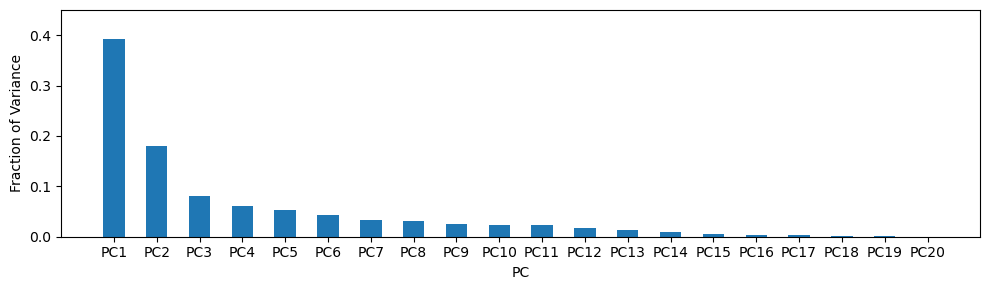

In [7]:
plt.figure(figsize=[10, 3], dpi=100)

plt.bar(feat_pc.columns, pca.explained_variance_ratio_, width=0.5)

plt.xlabel("PC")
plt.ylabel("Fraction of Variance")
plt.ylim(0, 0.45)

plt.tick_params(axis='x',which='minor', labelsize=11)

plt.tight_layout()
plt.savefig('./fig/badr_pc_var.png', facecolor='w')